# Analyzing NYC Taxi Fares with RAPIDS

[RAPIDS](https://rapids.ai/) is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, scikit-learn, and Dask.

The New York City Taxi and Limousine Commission provides (anonymized) data on all of the trips taken in New York as a series of Parquet files.

This notebook builds a simple data pipeline to load the data with cuDF (or Pandas), analyze it with cuML (or scikit-learn), find interesting patterns in the data, and build a simple predictive model on top of it.

In [1]:
import glob
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import cudf
import cuml

/home/ashwin/miniconda3/envs/all_cuda-118_arch-x86_64/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cudf.Series([1, 2])  # warmup

0    1
1    2
dtype: int64

## Get the data

In [3]:
def download(url, fname):
    """
    Download file from `url`, writing the result to `fname`.
    If `fname` already exists, do nothing.
    """
    # this code adapted from the tqdm examples
    # https://github.com/tqdm/tqdm/blob/master/examples/tqdm_requests.py
    if os.path.exists(fname):
        return
    response = requests.get(url, stream=True)
    with tqdm.wrapattr(
        open(fname, "wb"), "write",
        unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
        desc=fname, total=int(response.headers.get('content-length', 0))
    ) as fout:
        for chunk in response.iter_content(chunk_size=4096):
            fout.write(chunk)

def download_taxi_data(n):
    """
    Download `n` months of taxi data.
    """
    base = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
    fname = "yellow_tripdata_2021-{i:02d}.parquet"
    url = base + fname
    for i in range(1, n+1):
        download(url.format(i=i), fname.format(i=i))
    
def download_taxi_zones():
    download(
        "https://raw.githubusercontent.com/shwina/rapids-tutorial-gtc-2023/master/taxi_zones.csv?token=GHSAT0AAAAAAB4LHVK6US5ICH2ZZMTAVXMUY7YAMHQ",
        "taxi_zones.csv"
    )
    
download_taxi_data(1)
download_taxi_zones()

# Part 1: Loading and Preparing Data

## Reading the data

First, we'll read the data into a Pandas dataframe using the `pandas.read_parquet()` function. Then, we'll see how to do the same thing with cuDF.

In [4]:
%%time
# TODO: Read the CSV with cudf into gdf

df = pd.read_parquet(list(glob.glob("yellow*.parquet")))
display(df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.00,0.5,0.00,0.00,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.50,0.5,8.65,0.00,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.50,0.5,6.05,0.00,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.50,0.5,4.06,0.00,0.3,24.36,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369764,2,2021-01-31 23:03:00,2021-01-31 23:33:00,NaN,8.89,NaN,None,229,181,0,27.78,0.00,0.5,7.46,0.00,0.3,38.54,NaN,NaN
1369765,2,2021-01-31 23:29:00,2021-01-31 23:51:00,NaN,7.43,NaN,None,41,70,0,32.58,0.00,0.5,0.00,6.12,0.3,39.50,NaN,NaN
1369766,2,2021-01-31 23:25:00,2021-01-31 23:38:00,NaN,6.26,NaN,None,74,137,0,16.85,0.00,0.5,3.90,0.00,0.3,24.05,NaN,NaN
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,NaN,19.70,NaN,None,265,188,0,53.68,0.00,0.5,0.00,0.00,0.3,54.48,NaN,NaN


CPU times: user 709 ms, sys: 278 ms, total: 986 ms
Wall time: 171 ms


In [5]:
%%time
# TODO: Read the CSV with cudf into gdf

gdf = cudf.read_parquet(list(glob.glob("yellow*.parquet")))
display(gdf)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.00,0.5,0.00,0.00,0.3,11.80,2.5,<NA>
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,<NA>
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.50,0.5,8.65,0.00,0.3,51.95,0.0,<NA>
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.50,0.5,6.05,0.00,0.3,36.35,0.0,<NA>
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.50,0.5,4.06,0.00,0.3,24.36,2.5,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369764,2,2021-01-31 23:03:00,2021-01-31 23:33:00,<NA>,8.89,<NA>,<NA>,229,181,0,27.78,0.00,0.5,7.46,0.00,0.3,38.54,<NA>,<NA>
1369765,2,2021-01-31 23:29:00,2021-01-31 23:51:00,<NA>,7.43,<NA>,<NA>,41,70,0,32.58,0.00,0.5,0.00,6.12,0.3,39.50,<NA>,<NA>
1369766,2,2021-01-31 23:25:00,2021-01-31 23:38:00,<NA>,6.26,<NA>,<NA>,74,137,0,16.85,0.00,0.5,3.90,0.00,0.3,24.05,<NA>,<NA>
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,<NA>,19.70,<NA>,<NA>,265,188,0,53.68,0.00,0.5,0.00,0.00,0.3,54.48,<NA>,<NA>


CPU times: user 279 ms, sys: 35.4 ms, total: 314 ms
Wall time: 314 ms


The data for 2021 several million rows, which would take too long to analyze with Pandas. For this demo, we'll use just the first million rows, but you're welcome to try it yourself with the full dataset!

In [6]:
df = df.iloc[:1_000_000]
gdf = gdf.iloc[:1_000_000]

## Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

1. We'll work with just a subset of columns
2. We'll remove any extraneous spaces from column names and change them to all lowercase
3. We'll cast columns to the appropriate data types
3. For simplicity, we'll replace missing values ("nulls") with a sentinel value -1

In [7]:
def clean_columns(df, columns_to_keep, column_renames):
    # rename columns
    colname_cleanup = {col: col.strip().lower() for col in df.columns}
    df = df.rename(columns=colname_cleanup)
    df = df.rename(column_renames, axis=1)

    # Simplify the payment_type column
    df["is_credit_card"] = df["payment_type"] == 1

    for col in df.columns:
        # drop anything not in our expected list
        if col not in columns_to_keep:
            print(f"Dropping ({col})")
            df = df.drop(columns=col)
            continue
            
        # cast int64->int32, float64->float32
        dtype = df[col].dtype
        if dtype.kind in {'i', 'f'}:            
            if dtype.itemsize == 8:
                df[col] = df[col].astype(dtype.kind + str(dtype.itemsize))
            df[col] = df[col].fillna(-1)
            
    return df

columns_to_keep = {
    'pickup_datetime',                                                                                                                                                                
    'dropoff_datetime',                                                                                                                                                                
    'passenger_count',                                                                                                                                                                
    'pickup_longitude',                                                                                                                                                               
    '%pickup_latitude',                                                                                                                                                                
    'rate_code',                                                                                                                                                                      
    'fare_amount',
    'payment_type',
    'pickup_location',                                                                                                                                                                
    'dropoff_location',                                                                                                                                                               
    'airport_fee',
}

column_renames = {
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'ratecodeid': 'rate_code',
    'pulocationid': 'pickup_location',
    'dolocationid': 'dropoff_location'
}

In [40]:
%%time

df = clean_columns(df, columns_to_keep, column_renames)
print(df.__class__)
display(df)

KeyError: 'payment_type'

In [9]:
%%time
# TODO: RAPIDS approach - same as Pandas, but generate 'gdf' as output

gdf = clean_columns(gdf, columns_to_keep, column_renames)
print(gdf.__class__)
display(gdf)

Dropping (vendorid)
Dropping (trip_distance)
Dropping (store_and_fwd_flag)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)
Dropping (is_credit_card)
<class 'cudf.core.dataframe.DataFrame'>


,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,payment_type,fare_amount,airport_fee
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,2,8.0,-1.0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,2,3.0,-1.0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,1,42.0,-1.0
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,1.0,138,132,1,29.0,-1.0
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,1,16.5,-1.0
...,...,...,...,...,...,...,...,...,...
999995,2021-01-25 17:16:08,2021-01-25 17:32:53,1.0,1.0,230,144,1,13.0,-1.0
999996,2021-01-25 17:43:41,2021-01-25 17:58:42,2.0,1.0,107,140,1,12.0,-1.0
999997,2021-01-25 17:33:52,2021-01-25 17:39:46,1.0,1.0,90,234,1,6.0,-1.0
999998,2021-01-25 17:44:37,2021-01-25 17:48:46,1.0,1.0,107,170,1,5.0,-1.0


CPU times: user 73.7 ms, sys: 50.3 ms, total: 124 ms
Wall time: 127 ms


For clarity, we'll replace the `payment type` column with an `is_credit_card` column:

In [10]:
# add a feature:

df['is_credit_card'] = df['payment_type'] == 1
gdf['is_credit_card'] = gdf['payment_type'] == 1
del df['payment_type']
del gdf['payment_type']

## Look at some key stats

We'll plot the data using the Seaborn library, which you can install via `pip install seaborn`. For a more general guide on how to use RAPIDS with most of the popular visualization libraries, see the viz gallery in our docs: https://docs.rapids.ai/visualization

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

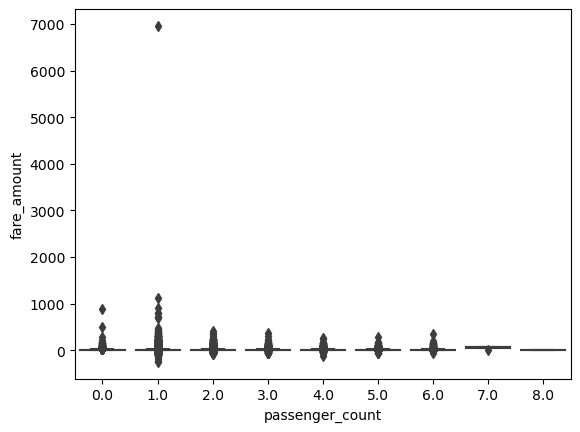

In [11]:
sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

## Filter the data

We'll apply a list of filter conditions to throw out records with missing or outlier values:

In [12]:
%%time

query = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
]
gdf = gdf.query(' and '.join(query)).copy()
gdf = gdf.reset_index(drop=True)
# inspect the results of cleaning
display(gdf)

,pickup_datetime,dropoff_datetime,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,1.0,142,43,8.0,-1.0,False
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,1.0,238,151,3.0,-1.0,False
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,1.0,132,165,42.0,-1.0,True
3,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,1.0,68,33,16.5,-1.0,True
4,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.0,224,68,8.0,-1.0,True
...,...,...,...,...,...,...,...,...,...
952965,2021-01-25 17:16:08,2021-01-25 17:32:53,1.0,1.0,230,144,13.0,-1.0,True
952966,2021-01-25 17:43:41,2021-01-25 17:58:42,2.0,1.0,107,140,12.0,-1.0,True
952967,2021-01-25 17:33:52,2021-01-25 17:39:46,1.0,1.0,90,234,6.0,-1.0,True
952968,2021-01-25 17:44:37,2021-01-25 17:48:46,1.0,1.0,107,170,5.0,-1.0,True


CPU times: user 269 ms, sys: 9.2 ms, total: 278 ms
Wall time: 276 ms


Looking at the data again, we see that we still have a signficant number of outliers. Later, we'll see why this is the case.

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

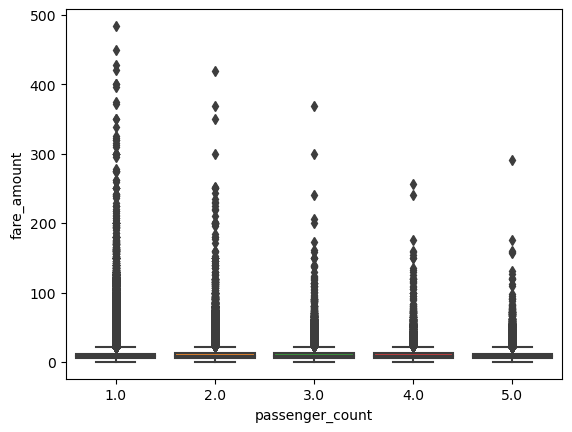

In [13]:
sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

## Part 2: Feature engineering and user-defined functions

We're going to add a few more features to our dataset to do more interesting analysis:

1. First, we're going to add the pickup and dropoff coordinates (latitudes/longitudes) for each trip. All we have right now are the pickup and dropoff "location IDs" for each trip. Another dataset (`taxi_zones.csv`) contains the  coordinates corresponding to each location ID. We'll see how to use the `merge` function to combine the two datasets.

2. Next, we'll compute the trip distance from the pickup and dropoff coordinates using the [Haversine Distance Formula](https://en.wikipedia.org/wiki/Haversine_formula).

3. Finally, we'll extract additional useful variables from the `pickup_datetime` field using cuDF's datetime functionality.

### Combining datasets with `merge()`

The data in `taxi_zones.csv` contains the coordinates for each location. The `'x'` and `'y'` columns refer to the longitute and latitude respectively of each location:

In [14]:
zones = cudf.read_csv("taxi_zones.csv")
zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,x,y
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.847422,40.864474
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.188484,40.552659
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,-73.852215,40.897932
259,260,0.133514,0.000422,Woodside,260,Queens,-73.906306,40.744235
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,-74.013023,40.709139
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,-73.946510,40.775932


There's something fishy about this dataset though: the `LocationID` column contains non-unique values, meaning that the same location ID maps to more than one zone:

In [15]:
zones["LocationID"].value_counts()

103    3
56     2
233    1
111    1
259    1
      ..
86     1
108    1
107    1
208    1
256    1
Name: LocationID, Length: 260, dtype: int32

In [16]:
zones[(zones["LocationID"] == 103) | (zones["LocationID"] == 56)]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,x,y
55,56,0.056848,0.000181,Corona,56,Queens,-73.858845,40.741407
56,57,0.019271,0.000018,Corona,56,Queens,-73.853582,40.751819
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.045288,40.689860
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.040771,40.698769
104,105,0.077425,0.000369,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.019073,40.688784


For this demonstration, we'll just drop those location IDs:

In [43]:
dup_rows = zones[(zones["LocationID"] == 103) | (zones["LocationID"] == 56)]
zones = zones.drop(dup_rows.index, axis=0)
zones = zones.reset_index(drop=True)

In [44]:
def add_pickup_and_dropoff_coordinates(df, zones):
    pickup_coordinates = zones.set_index(["LocationID"]).loc[gdf["pickup_location"]][["x", "y"]]
    dropoff_coordinates = zones.set_index(["LocationID"]).loc[gdf["dropoff_location"]][["x", "y"]]
    pickup_coordinates = pickup_coordinates.reset_index(drop=True)
    dropoff_coordinates = dropoff_coordinates.reset_index(drop=True)
    df["pickup_latitude"] = pickup_coordinates["y"]
    df["pickup_longitude"] = pickup_coordinates["x"]
    df["dropoff_latitude"] = dropoff_coordinates["y"]
    df["dropoff_longitude"] = dropoff_coordinates["x"]
    return df

In [45]:
gdf = add_pickup_and_dropoff_coordinates(gdf, zones)

In [46]:
gdf

,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,hour,year,month,day,day_of_week,is_weekend,h_distance
0,1.0,1.0,142,43,8.0,-1.0,False,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
1,1.0,1.0,238,151,3.0,-1.0,False,40.791705,-73.973049,40.797962,-73.968168,0,2021,1,1,4,0,0.808003
2,1.0,1.0,132,165,42.0,-1.0,True,40.646985,-73.786533,40.620924,-73.956825,0,2021,1,1,4,0,14.659199
3,1.0,1.0,68,33,16.5,-1.0,True,40.748428,-73.999917,40.695798,-73.995250,0,2021,1,1,4,0,5.865318
4,1.0,1.0,224,68,8.0,-1.0,True,40.731821,-73.976598,40.748428,-73.999917,0,2021,1,1,4,0,2.696283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940545,1.0,1.0,230,144,13.0,-1.0,True,40.759818,-73.984196,40.720889,-73.996919,17,2021,1,25,0,0,4.459401
940546,2.0,1.0,107,140,12.0,-1.0,True,40.736824,-73.984052,40.765484,-73.954739,17,2021,1,25,0,0,4.031519
940547,1.0,1.0,90,234,6.0,-1.0,True,40.742279,-73.996971,40.740337,-73.990458,17,2021,1,25,0,0,0.589685
940548,1.0,1.0,107,170,5.0,-1.0,True,40.736824,-73.984052,40.747746,-73.978492,17,2021,1,25,0,0,1.301661


### Using datetime functions

In [47]:
def add_datetime_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df    

In [48]:
%%time

# actually add the features
gdf = add_datetime_features(gdf)
gdf

KeyError: 'pickup_datetime'

### Computing the trip distance using a user-defined function: `apply()`

In [49]:
%%time

from math import asin, cos, pi, sin, sqrt

def haversine_distance_kernel(row):
    x_1, y_1, x_2, y_2 = (
        row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]
    )
    x_1 = pi/180 * x_1
    y_1 = pi/180 * y_1
    x_2 = pi/180 * x_2
    y_2 = pi/180 * y_2

    dlon = y_2 - y_1
    dlat = x_2 - x_1
    a = sin(dlat/2)**2 + cos(x_1) * cos(x_2) * sin(dlon/2)**2

    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
        
    return c * r


CPU times: user 20 µs, sys: 6 µs, total: 26 µs
Wall time: 34.6 µs


In [50]:
df = gdf.to_pandas()

In [28]:
%%time

df["h_distance"] = df.apply(haversine_distance_kernel, axis=1)
df.head()

CPU times: user 9.78 s, sys: 302 ms, total: 10.1 s
Wall time: 9.99 s


,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,hour,year,month,day,day_of_week,is_weekend,h_distance
0,1.0,1.0,142,43,8.0,-1.0,False,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
1,1.0,1.0,238,151,3.0,-1.0,False,40.791705,-73.973049,40.797962,-73.968168,0,2021,1,1,4,0,0.808003
2,1.0,1.0,132,165,42.0,-1.0,True,40.646985,-73.786533,40.620924,-73.956825,0,2021,1,1,4,0,14.659199
3,1.0,1.0,68,33,16.5,-1.0,True,40.748428,-73.999917,40.695798,-73.995250,0,2021,1,1,4,0,5.865318
4,1.0,1.0,224,68,8.0,-1.0,True,40.731821,-73.976598,40.748428,-73.999917,0,2021,1,1,4,0,2.696283


The call to `apply()` is much faster on the GPU. In fact, much of the time spent in the call to `apply()` is in JIT compilation. If you run the UDF again, we'll see that it takes a very small fraction of time compared to the first run.

With the JIT overhead, we see a speedup of about **5x**. Without JIT overhead, the speedup is about **~800x**!

In [51]:
%%time

gdf["h_distance"] = gdf.apply(haversine_distance_kernel, axis=1)
gdf.head()

CPU times: user 7.04 ms, sys: 7.2 ms, total: 14.2 ms
Wall time: 12.1 ms


,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,hour,year,month,day,day_of_week,is_weekend,h_distance
0,1.0,1.0,142,43,8.0,-1.0,False,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
1,1.0,1.0,238,151,3.0,-1.0,False,40.791705,-73.973049,40.797962,-73.968168,0,2021,1,1,4,0,0.808003
2,1.0,1.0,132,165,42.0,-1.0,True,40.646985,-73.786533,40.620924,-73.956825,0,2021,1,1,4,0,14.659199
3,1.0,1.0,68,33,16.5,-1.0,True,40.748428,-73.999917,40.695798,-73.995250,0,2021,1,1,4,0,5.865318
4,1.0,1.0,224,68,8.0,-1.0,True,40.731821,-73.976598,40.748428,-73.999917,0,2021,1,1,4,0,2.696283


For more advanced spatial calculations, check out cuSpatial (https://medium.com/rapids-ai/releasing-cuspatial-to-accelerate-geospatial-and-spatiotemporal-processing-b686d8b32a9).


# Part 3: Exploratory Analysis and Machine Learning

Let's say we're studying consumer behavior on behalf of the taxi commission. Are there a couple of clear "types" of rides that come up again and again? What are some of the key patterns we see in the data? Can we reliably predict some elements of user behavior?

Let's just do this on GPU, because it's faster and the code only differs by using `cuml.` instead of `sklearn.`

In [33]:
%matplotlib inline

In [34]:
from matplotlib import pyplot as plt

In [36]:
gdf.head()

,passenger_count,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,hour,year,month,day,day_of_week,is_weekend,h_distance
0,1.0,1.0,142,43,8.0,-1.0,False,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
1,1.0,1.0,238,151,3.0,-1.0,False,40.791705,-73.973049,40.797962,-73.968168,0,2021,1,1,4,0,0.808003
2,1.0,1.0,132,165,42.0,-1.0,True,40.646985,-73.786533,40.620924,-73.956825,0,2021,1,1,4,0,14.659199
3,1.0,1.0,68,33,16.5,-1.0,True,40.748428,-73.999917,40.695798,-73.995250,0,2021,1,1,4,0,5.865318
4,1.0,1.0,224,68,8.0,-1.0,True,40.731821,-73.976598,40.748428,-73.999917,0,2021,1,1,4,0,2.696283


In [37]:
%%time

gdf_standardized = cuml.preprocessing.RobustScaler().fit_transform(gdf)
cu_kmeans = cuml.cluster.KMeans(n_clusters=5)
clusters_gpu = cu_kmeans.fit_predict(gdf_standardized)

CPU times: user 608 ms, sys: 143 ms, total: 751 ms
Wall time: 810 ms


In [38]:
clusters_gpu.value_counts()

2    688448
0    189097
3     41270
4     21722
1        13
dtype: int32

In [39]:
# Add a few interesting variables to help summarize the data
gdf_plot = gdf.copy()
gdf_plot["cluster"] = clusters_gpu
gdf_plot["short_trip"] = gdf_plot["trip_distance"] < 1.01 # About the 25th percentile
gdf_plot["is_rush_est"] = ((gdf_plot.hour >= 10) & (gdf_plot.hour <= 14)) | \
                                ((gdf_plot.hour >= 21) & (gdf_plot.hour <= 24))

# actually do the plot
sns.lmplot(data=gdf_plot.to_pandas(), x="pickup_longitude", y="pickup_latitude", x_jitter=0.01, y_jitter=0.01,
           hue="cluster", col="is_credit_card", row="is_rush_est", fit_reg=False, scatter_kws={"s": 1})

KeyError: 'trip_distance'

In [ ]:
## DRAFT - try umap

gdf_sample = gdf.sample(50000).reset_index()

umap = cuml.manifold.UMAP() 
umap_out = umap.fit_transform(
     cuml.preprocessing.RobustScaler().fit_transform(gdf_sample))

gdf_sample["umap_x"] = umap_out.iloc[:,0]
gdf_sample["umap_y"] = umap_out.iloc[:,1]

In [ ]:
import hvplot.cudf
import holoviews as hv

# generate hvplot points chart using cudf DataFrame
gdf_sample.hvplot.scatter(x="umap_x", y="umap_y", by=["is_weekend", "is_credit_card"], s=0.1,
                          subplots=False, hover_cols="all").opts(
    title="Scatter Plot", width=500, height=500
)

In [ ]:
# explorer = hvplot.explorer(gdf_sample)
# explorer.param.set_param(kind='scatter', x='umap_x', y="umap_y")
# explorer

In [ ]:
sns.pairplot(
    gdf_sample[['is_rush_hour', 'trip_distance', 'hour', 'is_credit_card']].to_pandas(),
    hue='is_credit_card'
)

In [ ]:
sns.lmplot(data=gdf_sample.to_pandas(), x="umap_x", y="umap_y",
           hue="is_credit_card", fit_reg=False, scatter_kws={"s": 2})

# Build a supervised model to predict payment form

Let's imagine you're a taxi operator trying to understand consumer payment behavior. What types of rides will be paid by credit card and what types via cash? Let's build a predictive model to help us understand.

## Start by splitting training and test data.

We'll want to know how accurate our model is, so let's start by splitting the dataset into "train" and "test" subsets randomly.

In [ ]:
%time

# First let's split using Pandas and scikit-learn
import sklearn

y_df = df["is_credit_card"]
X_df = df.drop(columns="is_credit_card")

# Split our dataframes
X_train_df, X_test_df, y_train_df, y_test_df = sklearn.model_selection.train_test_split(X_df, y_df)

# Create array versions of these dataframes
X_train_np, X_test_np = (X_train_df.to_numpy(np.float32), X_test_df.to_numpy(np.float32))
y_train_np, y_test_np = (y_train_df.to_numpy(np.float32), y_test_df.to_numpy(np.float32))

len(X_train_df)

When we think of ML, we often think of running large predictive models. But scikit-learn also provides a huge toolbox of utilities like preprocessing, data splitting, and more that are essential for ML practitioners. cuML contains GPU-based analogues of these utilities so that your data does not need to take a round trip back to CPU just to partition it.

In [ ]:
%%time

# Now do the same on GPU

y_gdf = gdf["is_credit_card"]
X_gdf = gdf.drop(columns="is_credit_card")

# Split our dataframes
X_train_gdf, X_test_gdf, y_train_gdf, y_test_gdf = sklearn.model_selection.train_test_split(X_gdf, y_gdf)

# Create array versions of these dataframes
X_train_gpu, X_test_gpu = (X_train_gdf.to_cupy(np.float32), X_test_gdf.to_cupy(np.float32))
y_train_gpu, y_test_gpu = (y_train_gdf.to_cupy(np.float32), y_test_gdf.to_cupy(np.float32))

len(X_train_gdf)

In [ ]:
X_gdf.columns

### Fit a simple supervised model with cuML

cuML supports a large range of supervised models, all emulating the scikit-learn interfaces. See the README (https://github.com/rapidsai/cuml) for a recent list. Here, we'll try a very common but powerful model - a random forest ensemble for classification. Specifically, we want to classify whether the trip was paid for by credit card (the positive class) or not.

In [ ]:
from sklearn.ensemble import RandomForestClassifier as skRandomForestClassifier
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier

In [ ]:
%%time

# Scikit-learn will parallelize over all CPU cores with n_jobs=-1

sk_model = skRandomForestClassifier(n_estimators=250, n_jobs=-1)
sk_model.fit(X_train_np, y_train_np)

In [ ]:
%%time

# TODO: Build a similar model on GPU with cuML

cuml_model = cuRandomForestClassifier(n_estimators=250)
cuml_model.fit(X_train_gpu, y_train_gpu)

In [ ]:
# Let's use the model to predict from the test set and evaluate the predictions' accuracy

rf_predictions = cuml_model.predict(X_test_gpu)

# Compute the probability that the transaction used a credit card, according to our model
rf_probabilities = cuml_model.predict_proba(X_test_gpu)[:,1]

## Just as cuML provides utilities for data preprocessing and splitting, it also provides a
## wide set of GPU-accelerated metrics, like accuracy and AUC score. These are fast and
## ensure you don't need to fall back to CPU for any of your pipeline.
print("Accuracy: ", cuml.metrics.accuracy.accuracy_score(y_test_gpu, rf_predictions))
print("AUC: ", cuml.metrics.roc_auc_score(y_test_gpu, rf_probabilities))

sns.kdeplot(x=rf_probabilities.get(), hue=y_test_gpu.get())

In [ ]:
## XXX Drop this before final - just for debugging

featimp = pd.DataFrame({
    "feat": X_df.columns,
    "imp": sk_model.feature_importances_})
featimp.sort_values("imp")